In [ ]:
!pip install -q gdown httpimport
![ -e word2vec.tar.xz ] || gdown 'https://drive.google.com/uc?id=1v6D8IjYVFlonhQuN_J3PML5KSVQSpbED' -O word2vec.tar.xz
![ -d word2vec ] || tar Jxf word2vec.tar.xz

Downloading...
From: https://drive.google.com/uc?id=1v6D8IjYVFlonhQuN_J3PML5KSVQSpbED
To: /content/word2vec.tar.xz
395MB [00:02, 152MB/s]


In [ ]:
%pylab inline

import collections
import codecs
import copy
import string

import numpy as np
from scipy.optimize import minimize
from scipy.linalg import orthogonal_procrustes, svd
from scipy.spatial import distance
from sklearn.neighbors import KDTree
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

Populating the interactive namespace from numpy and matplotlib


# Preparing resources

At the beginning we have to prepare and clean vocabulary and embeddings. 

Then we need to select set of gender neutral words as well as set of pairs of female-male words.

Finally we also need a set of wrongfully biased words that we will debias.

In [ ]:
# Word embeddings assign a vector to each word. To use them we need three things:
# 1. the embeddings themselves
# 2. a dictionary from words to their embedding ids
# 3. an inverse dictionary

Embedding = collections.namedtuple(
    'Embedding',
    ['vec', 'word2idx', 'idx2word'])

def load_embedding(base_path):
    # Words are filtered at the beginning:
    # - we take only 60000 most common words
    # - we remove all digits, punctuation and words consisting uppercase letters 
    pre_vec = np.load(base_path + '.npy')[:50000]
    pre_idx2word = [l.strip() for l in codecs.open(
                      base_path + '.txt', 'r', 'utf-8')][:50000]
    vec = []
    idx2word = []
    for (i,w) in enumerate(pre_idx2word):
        w = w.replace("_", " ")
        if (w.islower() or w[1:].islower()) and len(w) < 20 and set(w).isdisjoint(set(string.punctuation)):
            vec.append(pre_vec[i])
            idx2word.append(w)
    word2idx = {w:i for (i,w) in enumerate(idx2word)}
    voc = {w for w in idx2word}
    return Embedding(np.array(vec), word2idx, idx2word)

def load_and_normalize_embedding(base_path):
    emb = load_embedding(base_path)
    voc = {w for w in emb.idx2word}
    # Normalize word vectors
    epsilon = 0.000001
    for idx in range(len(emb.vec)):
        v = emb.vec[idx]
        norm = np.linalg.norm(v, ord=2) + epsilon
        emb.vec[idx] /= norm

    return voc, emb

# LoadZ word embeddings: Word2vec and FastText
vocab, word2vec = load_and_normalize_embedding('word2vec/word2vec_GoogleNews_200k')
# vocab, ftext = load_and_normalize_embedding('word2vec/fasttext_wikien_200k')

In [ ]:
# In the article mentioned above there are listed 218 gender-specific words (selected by classifier and by hand)
# We took those words and used some of them as 30 gender-defining pairs used to capture direction (subspace) of the bias.
gender_defining_pairs = np.array([['he', 'she'],
                                  ['his', 'hers'],
                                  ['him', 'her'],
                                  ['himself', 'herself'],
                                  ['man', 'woman'],
                                  ['men', 'women'],
                                  ['father', 'mother'],
                                  ['dad', 'mom'],
                                  ['son', 'daughter'],
                                  ['sons', 'daughters'],
                                  ['husband', 'wife'],
                                  ['husbands', 'wives'],
                                  ['boy', 'girl'],
                                  ['boys', 'girls'],
                                  ['brother', 'sister'],
                                  ['grandfather', 'grandmother'],
                                  ['grandson', 'granddaughter'],
                                  ['uncle', 'aunt'],
                                  ['uncles', 'aunts'],
                                  ['nephew', 'niece'],
                                  ['boyfriend', 'girlfriend'],
                                  ['paternity', 'maternity'],
                                  ['guy', 'gal'],
                                  ['male', 'female'],
                                  ['spokesman', 'spokeswoman'],
                                  ['chairman', 'chairwoman'],
                                  ['businessman', 'businesswoman'],
                                  ['king', 'queen'],
                                  ['prince', 'princess']
                                  ])

gender_specific = ['actress', 'lady', 'deer', 'ladies',  'congressman', 'bull', 'businessmen', 'widow', 'bride', 'prostate cancer',
                   'lesbian',  'maiden', 'younger brother', 'lads', 'lion', 'gentleman', 'fraternity', 'bachelor', 'bulls', 'colt', 'salesman',
                   'dude', 'beard', 'filly', 'lesbians', 'councilman', 'actresses', 'gentlemen', 'stepfather', 'monks', 'ex girlfriend', 'lad',
                   'sperm', 'testosterone', 'maid', 'daddy', 'mare', 'fiance', 'fiancee', 'kings', 'waitress', 'maternal', 'heroine', 'sir',
                   'stud', 'mistress', 'lions', 'estranged wife', 'womb', 'grandma', 'estrogen', 'ex boyfriend', 'widows', 'gelding', 'diva',
                   'teenage girls', 'nuns', 'czar', 'ovarian cancer', 'countrymen', 'teenage girl', 'penis', 'bloke', 'nun', 'brides',
                   'housewife', 'moms', 'spokesmen', 'suitors', 'menopause', 'dads', 'monastery', 'motherhood', 'brethren', 'stepmother', 'prostate', 'hostess',
                   'twin brother', 'schoolboy', 'brotherhood', 'fillies', 'stepson', 'congresswoman', 'witch', 'monk', 'viagra', 'suitor',
                   'sorority', 'macho', 'eldest son', 'statesman', 'schoolgirl', 'fathered', 'goddess', 'hubby', 'stepdaughter', 'blokes',
                   'dudes', 'strongman', 'uterus', 'studs', 'mama', 'godfather', 'hens', 'hen', 'mommy', 'estranged husband', 'elder brother',
                   'boyhood', 'baritone', 'grandmothers', 'grandpa', 'feminism', 'countryman', 'stallion', 'heiress', 'queens', 'witches',
                   'semen', 'fella', 'chap', 'widower', 'salesmen', 'convent', 'vagina', 'beau', 'beards', 'handyman', 'twin sister', 'maids',
                   'gals', 'housewives', 'horsemen', 'obstetrics', 'fatherhood', 'councilwoman', 'princes', 'matriarch', 'colts', 'ma',
                   'fraternities', 'pa', 'fellas', 'councilmen', 'dowry', 'barbershop', 'fraternal', 'fathers', 'mothers', 'grandsons', 
                   'granddaughters', 'boyfriends', 'girlfriends', 'brothers', 'sisters', 'males', 'females', 'nephews', 'nieces',
                   'ballerina'] + [pair[0] for pair in gender_defining_pairs] + [pair[1] for pair in gender_defining_pairs]

# Checking whether all our words are in vocabulary
for word in gender_specific:
    assert word in vocab

In [ ]:
# All the words that aren't gender specific are neutral and shouldn't be biased.
gender_neutrals = copy.deepcopy(vocab)
for w in gender_specific:
    gender_neutrals.remove(w)

In [ ]:
# Different kinds of stereotypes: religion, nationality, race.

religion_defining_pairs = np.array([['Christianity', 'Judaism', 'Islam'],
                                    ['priest', 'rabbi', 'imam'],
                                    ['church', 'synagogue', 'mosque'],
                                    ['Christian', 'Jew', 'Muslim'],
                                    ['Bible', 'Torah', 'Quran'],
                                    ['Vatican', 'Israel', 'Mecca']])

religion_specific = ['cross', 'God', 'baptism'] + [word for row in religion_defining_pairs for word in row]
religion_neutrals = copy.deepcopy(vocab)
for w in religion_specific:
    assert w in vocab
    religion_neutrals.remove(w)


country_defining_pairs = np.array([['Germany', 'England', 'France', 'Italy', 'Japan', 'Russia'],
                                   ['German', 'English', 'French', 'Italian','Japanese','Russian'],
                                   ['Berlin', 'London', 'Paris', 'Rome', 'Tokyo', 'Moscow']])
country_specific = [word for row in country_defining_pairs for word in row]
country_neutrals = copy.deepcopy(vocab)
for w in country_specific:
    assert w in vocab
    country_neutrals.remove(w)


race_defining_pairs = np.array([['black', 'white', 'yellow'], 
                                ['African', 'European', 'Asian']])
race_specific = [word for row in race_defining_pairs for word in row]
race_neutrals = copy.deepcopy(vocab)
for w in race_specific:
    assert w in vocab
    race_neutrals.remove(w)

In [ ]:
print("Vocabulary size:\t{}\nGender specific words:\t{}\nGender neutral words:\t{}\nGender defining pairs:\t{}\n\n".format(
    len(word2vec.idx2word), len(gender_specific), len(gender_neutrals), len(gender_defining_pairs)))

Vocabulary size:	42129
Gender specific words:	218
Gender neutral words:	41911
Gender defining pairs:	29




# Bias visualization

In [ ]:
pca = PCA(n_components=2)

def make_diagram(tuples):
    multidim_vecs = []
    num_tuples = len(tuples)
    tuple_len  = len(tuples[0])
    for multiword in tuples:
        for word in multiword:
            multidim_vecs.append(word2vec.vec[word2vec.word2idx[word]])
    plain_vecs = pca.fit_transform(multidim_vecs)

    plt.figure(figsize=(12, 12))
    for i in range(num_tuples):
        for j in range(tuple_len):
            if j == 0:
                x = plain_vecs[tuple_len * i + j]
                plt.scatter(x[0], x[1], c='b')
                plt.annotate(tuples[i][0], x)
            else:
                y = plain_vecs[tuple_len * i + j]
                plt.scatter(y[0], y[1], c='b')
                plt.plot((x[0], y[0]), (x[1], y[1]))
                plt.annotate(tuples[i][j], y)
    plt.show()

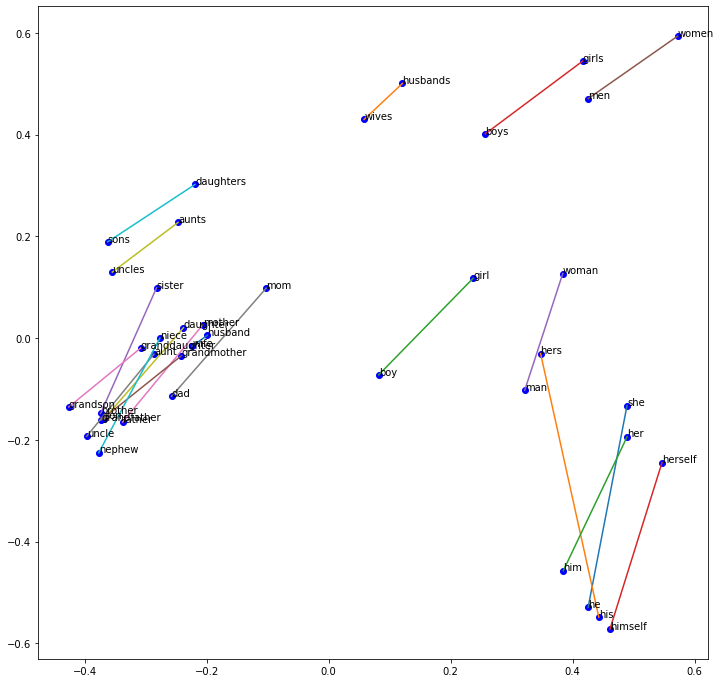

In [ ]:
make_diagram(gender_defining_pairs[:20])

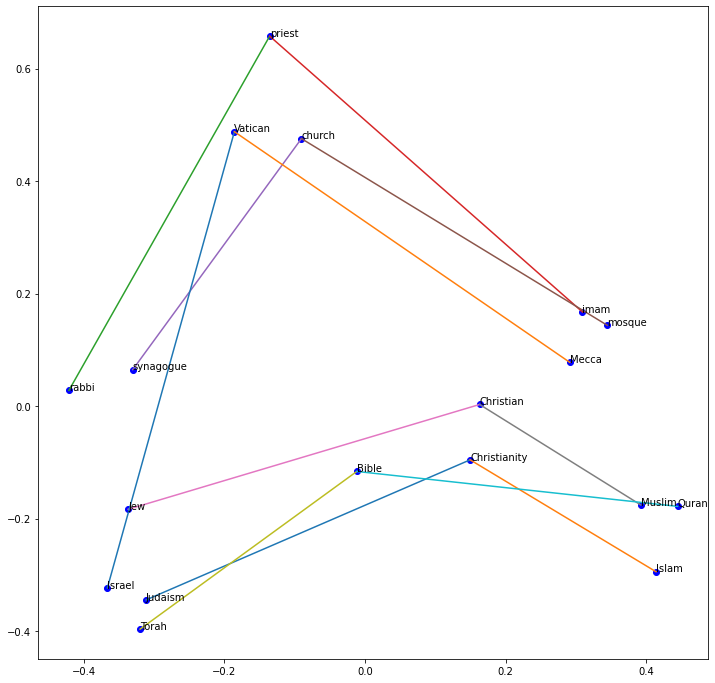

In [ ]:
make_diagram(religion_defining_pairs)

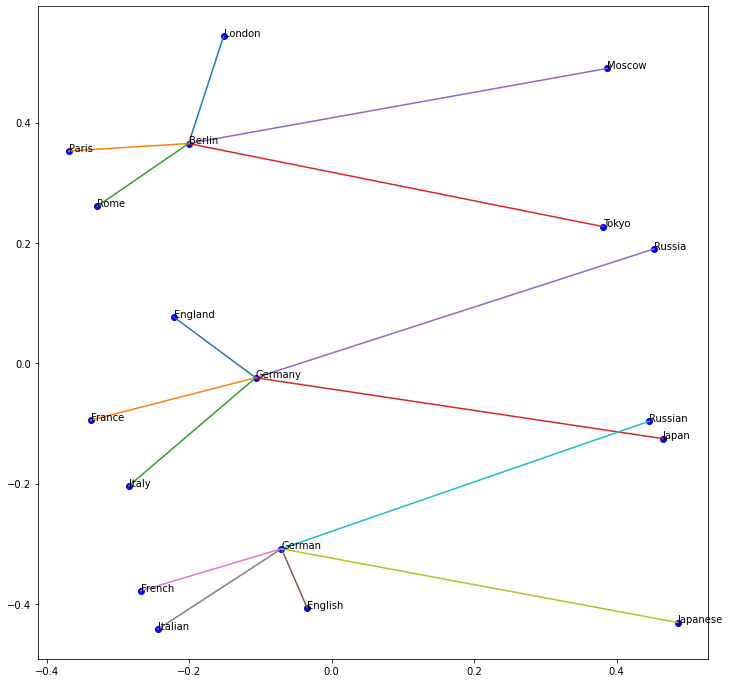

In [ ]:
make_diagram(country_defining_pairs)

# Determining stereotype subspace

Copying algorithm from:
https://papers.nips.cc/paper/6228-man-is-to-computer-programmer-as-woman-is-to-homemaker-debiasing-word-embeddings.pdf

Full version (with appendix):
https://arxiv.org/pdf/1607.06520.pdf

In [ ]:
def bias_subspace(vocab, defining_sets, k, embedding):
    '''
        Arguments:
        vocab         :  set of words in our dictionary
        defining_sets : sets of words D1, D2, ..., Dn
                        each set contaings analogous words, one for every class
                        in case of gender it can be for example: D1 = {king, queen}, D2 = {man, woman}, ...
        k >= 1        :  integer parameter, dimensionality of subspace
        embedding     :  word embeddings

        Outputs:
        base vectors of subspace determining given stereotype
    '''

    # Getting means of every defining subset   
    set_avg = [np.array([embedding.vec[embedding.word2idx[word]] for word in def_set]).mean(axis=0) for def_set in defining_sets]
    

    # Sum of outer products of (w - ro)
    dist_from_avg = []
    for i, def_set in enumerate(defining_sets):
        for word in def_set:
            d = embedding.vec[embedding.word2idx[word]] - set_avg[i]
            dist_from_avg.append(np.outer(d, d) / len(def_set))
    C = np.array(dist_from_avg).mean(axis=0)

    U, s, V = svd(C)
    return V[:k]

In [ ]:
gender_subspace = bias_subspace(vocab, gender_defining_pairs, 1, word2vec)

In [ ]:
religion_subspace = bias_subspace(vocab, religion_defining_pairs, 1, word2vec)

In [ ]:
country_subspace = bias_subspace(vocab, country_defining_pairs, 1, word2vec)

In [ ]:
race_subspace = bias_subspace(vocab, race_defining_pairs, 1, word2vec)

## Hard debiasing

In [ ]:
def projection(vec, subspace):
    # Calculates (v - v_B)
    # vec_proj = np.zeros((subspace.shape[0], vec.shape[0]))
    # for i in range(len(subspace)):
    #     vec_proj[i] = subspace[i] * (vec.dot(subspace[i].T))
    vec_proj = subspace * (vec.dot(subspace.T))
    return vec_proj.sum(axis=0)

def norm(vector):
    return np.linalg.norm(vector, ord=2)

In [ ]:
def hard_debiasing(to_neutralize, equality_sets, subspace, embedding):
    '''
        Arguments:
        to_neutralize  :  list of words to debias
        equality_sets  :  list of sets to equalize
                          each word from to_neutralize is made equally distant from every word from a set 
        subspace       :  subspace or direction in which the bias points
        embedding      :  current embeddings

        Returns:
        new_embedding  :  new, bias-free embeddings
    '''
    new_embedding = copy.deepcopy(embedding)

    for word in to_neutralize:
        idx = embedding.word2idx[word]
        word_projection = projection(embedding.vec[idx], subspace)
        neutralized_embedding = (embedding.vec[idx] - word_projection) / norm((embedding.vec[idx] - word_projection))
        new_embedding.vec[idx] = neutralized_embedding
    

    for equ_set in equality_sets:
        set_mean = np.array([embedding.vec[embedding.word2idx[word]] for word in equ_set]).mean(axis=0)
        set_mean_subspace = projection(set_mean, subspace)
        dif_mean = set_mean - set_mean_subspace
        for word in equ_set:
            idx = embedding.word2idx[word]
            word_projection = projection(embedding.vec[idx], subspace)
            neutralized_embedding = dif_mean + np.sqrt(1 - norm(dif_mean)**2) * ((word_projection - set_mean_subspace) /
                                                                                 norm(word_projection - set_mean_subspace)) 
            new_embedding.vec[idx] = neutralized_embedding

    return new_embedding

In [ ]:
gender_embedding = hard_debiasing(gender_neutrals, gender_defining_pairs, gender_subspace, word2vec)

In [ ]:
religion_embedding = hard_debiasing(religion_neutrals, religion_defining_pairs, religion_subspace, word2vec)

In [ ]:
country_embedding = hard_debiasing(country_neutrals, country_defining_pairs, country_subspace, word2vec)

In [ ]:
race_embedding = hard_debiasing(race_neutrals, race_defining_pairs, race_subspace, word2vec)

In [ ]:
ultimate_embedding = hard_debiasing(race_neutrals, race_defining_pairs, race_subspace,
                                    hard_debiasing(country_neutrals, country_defining_pairs, country_subspace, 
                                                   hard_debiasing(religion_neutrals, religion_defining_pairs, religion_subspace,
                                                                  hard_debiasing(gender_neutrals, gender_defining_pairs, gender_subspace, word2vec))))

## Soft debiasing

In [ ]:
# import torch

# x0 = torch.tensor(np.zeros([word2vec.vec.shape[1],word2vec.vec.shape[1]]), device='cuda:0', dtype=torch.double)
# t_emb = torch.tensor(word2vec.vec, device='cuda:0', dtype=torch.double)
# gender_neutral_embedding = [word2vec.vec[word2vec.word2idx[word]] for word in gender_neutrals]
# t_neutral = torch.tensor(gender_neutral_embedding, device='cuda:0', dtype=torch.double)
# t_subspace = torch.tensor(subspace, device='cuda:0', dtype=torch.double)

# projection(x0, t_emb, t_neutral, t_subspace, parameter = 0.2)

# # Tried to export everything to PyTorch to improve performance, but even single multiplication with result size (200000 x 200000) is too much.
# print(torch.mm(t_emb, torch.transpose(t_emb, 0, 1)).shape)

In [ ]:
def projection(x, embedding_vectors, gender_neutral, gender_subspace, parameter):
    transformation = x.reshape([embedding_vectors.shape[1],embedding_vectors.shape[1]])
    res = transformation.dot(embedding_vectors.T).T.dot(transformation.dot(embedding_vectors.T))
    res -= embedding_vectors.dot(embedding_vectors.T)
    res = np.linalg.norm(res, ord=2)**2
    res2 = transformation.dot(gender_neutral).T.dot(transformation.dot(gender_subspace))
    res2 = parameter * (np.linalg.norm(res2, ord=2)**2)
    return res + res2

In [ ]:
def soft_debias_correction(embedding, gender_neutral, gender_subspace, parameter = 0.2):
    '''
        Arguments:
        embedding_vectors       :  list of words to debias
        gender_neutral          :  list of gender neutral words  
        gender_subspace         :  subspace in which the bias points
        parameter               :  weight put on debias value. for big 'parameter' we would get same result as for hard_debiasing

        Returns:
        new_embedding  :  new, bias-free embedding
    '''
    new_embedding_res = copy.deepcopy(embedding) 
    x_0 = np.zeros([new_embedding_res.vec.shape[1],new_embedding_res.vec.shape[1]])
    # Added .x at the end below as minimize() outputs object of OptimizationResult type not output matrix
    transformation = minimize(lambda x: projection(x,new_embedding_res.vec, gender_neutral, gender_subspace, parameter), x_0, method = 'L-BFGS-B').x
    transformation = transformation.reshape([new_embedding_res.vec.shape[1], new_embedding_res.vec.shape[1]])
    # Had to add a few .T below, as matrix sizes didn't match.
    new_embedding_res = transformation.dot(new_embedding_res.vec.T).T / np.linalg.norm(transformation.dot(new_embedding_res.vec.T),ord=2,axis=1)
    return new_embedding_res


In [ ]:
new_embedding1 = soft_debias_correction(word2vec, gender_neutrals, subspace)

## Check debiasing

1.  Check distance to mascular words and to femine words. Idealy they should be the same for every neutral word.

2. Check best analogy generated by the model.

3. Maybe some visualization?

In [ ]:
def distance_check(embedding, new_embedding, biased_words, defining_pairs):
    old_score_he  = 0
    old_score_she = 0
    new_score_he  = 0
    new_score_she = 0
    pairs_dist = 0
    new_pairs_dist = 0
    for word in biased_words:
        for pair in defining_pairs:
            old_score_he  += norm(embedding.vec[embedding.word2idx[pair[0]]] - embedding.vec[embedding.word2idx[word]])
            old_score_she += norm(embedding.vec[embedding.word2idx[pair[1]]] - embedding.vec[embedding.word2idx[word]])
            new_score_he  += norm(new_embedding.vec[new_embedding.word2idx[pair[0]]] - new_embedding.vec[new_embedding.word2idx[word]])
            new_score_she += norm(new_embedding.vec[new_embedding.word2idx[pair[1]]] - new_embedding.vec[new_embedding.word2idx[word]])
    
    for pair in defining_pairs:
        pairs_dist += norm(embedding.vec[embedding.word2idx[pair[1]]] - embedding.vec[embedding.word2idx[pair[0]]])
        new_pairs_dist += norm(new_embedding.vec[new_embedding.word2idx[pair[1]]] - new_embedding.vec[new_embedding.word2idx[pair[0]]])


    print("Old sum of all distances between pairs: {:.4f}\nNew sum of all distances between pairs: {:.4f}".format(pairs_dist, new_pairs_dist))
    print("Old embedding 'he'  distance: {:.4f}\nOld embedding 'she' distance: {:.4f}\nDiff: {:.4f}".format(old_score_he,
                                                                                                            old_score_she,
                                                                                                            old_score_he - old_score_she))
    print("New embedding 'he'  distance: {:.4f}\nNew embedding 'she' distance: {:.4f}\nDiff: {:.4f}".format(new_score_he,
                                                                                                            new_score_she,
                                                                                                            new_score_he - new_score_she))

In [ ]:
distance_check(word2vec, gender_embedding, gender_neutrals, gender_defining_pairs)

Old sum of all distances between pairs: 21.4633
New sum of all distances between pairs: 21.9811
Old embedding 'he'  distance: 1666284.2197
Old embedding 'she' distance: 1665323.2772
Diff: 960.9426
New embedding 'he'  distance: 1665931.1125
New embedding 'she' distance: 1665931.1091
Diff: 0.0033


In [ ]:
def distance_check_religion(embedding, new_embedding, biased_words, defining_pairs):
    old_score_ch = 0
    old_score_je = 0
    old_score_mu = 0
    new_score_ch = 0
    new_score_je = 0
    new_score_mu = 0
    pairs_dist = 0
    new_pairs_dist = 0
    for word in biased_words:
        for pair in defining_pairs:
            old_score_ch += norm(embedding.vec[embedding.word2idx[pair[0]]] - embedding.vec[embedding.word2idx[word]])
            old_score_je += norm(embedding.vec[embedding.word2idx[pair[1]]] - embedding.vec[embedding.word2idx[word]])
            old_score_mu += norm(embedding.vec[embedding.word2idx[pair[2]]] - embedding.vec[embedding.word2idx[word]])
            new_score_ch += norm(new_embedding.vec[new_embedding.word2idx[pair[0]]] - new_embedding.vec[new_embedding.word2idx[word]])
            new_score_je += norm(new_embedding.vec[new_embedding.word2idx[pair[1]]] - new_embedding.vec[new_embedding.word2idx[word]])
            new_score_mu += norm(new_embedding.vec[new_embedding.word2idx[pair[2]]] - new_embedding.vec[new_embedding.word2idx[word]])
    
    for pair in defining_pairs:
        pairs_dist += norm(embedding.vec[embedding.word2idx[pair[1]]] - embedding.vec[embedding.word2idx[pair[0]]])
        pairs_dist += norm(embedding.vec[embedding.word2idx[pair[1]]] - embedding.vec[embedding.word2idx[pair[2]]])
        pairs_dist += norm(embedding.vec[embedding.word2idx[pair[2]]] - embedding.vec[embedding.word2idx[pair[0]]])
        new_pairs_dist += norm(new_embedding.vec[new_embedding.word2idx[pair[1]]] - new_embedding.vec[new_embedding.word2idx[pair[0]]])
        new_pairs_dist += norm(new_embedding.vec[new_embedding.word2idx[pair[1]]] - new_embedding.vec[new_embedding.word2idx[pair[2]]])
        new_pairs_dist += norm(new_embedding.vec[new_embedding.word2idx[pair[2]]] - new_embedding.vec[new_embedding.word2idx[pair[0]]])


    print("Old sum of all distances between religions: {:.4f}\nNew sum of all distances between religions: {:.4f}".format(pairs_dist, new_pairs_dist))
    print("Old embedding sum of distances to christian words: {:.4f}\nOld embedding sum of distances to jewish words: {:.4f}\nOld embedding sum of distances to muslim words: {:.4f}\nDiff: {:.4f}".format(
        old_score_ch, old_score_je, old_score_mu, abs(old_score_ch - old_score_je) + abs(old_score_ch - old_score_mu) + abs(old_score_mu - old_score_je)))
    print("New embedding sum of distances to christian words: {:.4f}\nNew embedding sum of distances to jewish words: {:.4f}\nNew embedding sum of distances to muslim words: {:.4f}\nDiff: {:.4f}".format(
        new_score_ch, new_score_je, new_score_mu, abs(new_score_ch - new_score_je) + abs(new_score_ch - new_score_mu) + abs(new_score_mu - new_score_je)))

In [ ]:
distance_check_religion(word2vec, religion_embedding, religion_neutrals, religion_defining_pairs)

Old sum of all distances between religions: 18.3754
New sum of all distances between religions: 14.1862
Old embedding sum of distances to christian words: 345818.3718
Old embedding sum of distances to jewish words: 346537.6705
Old embedding sum of distances to muslim words: 347328.4601
Diff: 3020.1766
New embedding sum of distances to christian words: 346628.7609
New embedding sum of distances to jewish words: 346628.7603
New embedding sum of distances to muslim words: 346628.7613
Diff: 0.0020


In [ ]:
distance_check(word2vec, country_embedding, country_neutrals, country_defining_pairs)

Old sum of all distances between pairs: 3.2507
New sum of all distances between pairs: 0.0000
Old embedding 'he'  distance: 174778.6158
Old embedding 'she' distance: 173764.8021
Diff: 1013.8137
New embedding 'he'  distance: 174398.4246
New embedding 'she' distance: 174398.4230
Diff: 0.0016


In [ ]:
distance_check(word2vec, race_embedding, race_neutrals, race_defining_pairs)

Old sum of all distances between pairs: 1.7147
New sum of all distances between pairs: 1.2217
Old embedding 'he'  distance: 115754.3059
Old embedding 'she' distance: 115842.6941
Diff: -88.3882
New embedding 'he'  distance: 115986.0024
New embedding 'she' distance: 115986.0039
Diff: -0.0016


In [ ]:
distance_check(word2vec, new_embedding1, gender_neutrals, gender_defining_pairs)

NameError: ignored

In [ ]:
def analogies_check(embedding, tests):
    '''
        Checking analogies of the type 'he is to x as she is to y'
        with x from tests
    '''
    T = KDTree(embedding.vec)
    for word in tests:
        q = [embedding.vec[embedding.word2idx[word]] + embedding.vec[embedding.word2idx['she']] - embedding.vec[embedding.word2idx['he']]]
        dist, ans = T.query(q,k=2)
        print("he is to {} as she is to {}".format(word, embedding.idx2word[ans[0][1]]))

In [ ]:
test_words = {"conservatism", "doctor", "coward", "shorts"}

print("Analogies generated by original embedding:")
analogies_check(word2vec, test_words)

Analogies generated by original embedding:
he is to conservatism as she is to feminism
he is to doctor as she is to nurse
he is to shorts as she is to skirts
he is to coward as she is to bitch


In [ ]:
print("Analogies generated by hard debiased embedding:")
analogies_check(gender_embedding, test_words)

Analogies generated by hard debiased embedding:
he is to conservatism as she is to feminism
he is to doctor as she is to physician
he is to shorts as she is to pants
he is to coward as she is to gal


In [ ]:
print("Analogies generated by soft debiased embedding:")
analogies_check(new_embedding1, test_words)

In [ ]:
def analogies_check_religion(embedding, tests):
    '''
        Checking analogies of the type 'he is to x as she is to y'
        with x from tests
    '''
    T = KDTree(embedding.vec)
    for word in tests:
        q = [embedding.vec[embedding.word2idx[word]] + embedding.vec[embedding.word2idx['Christianity']] - embedding.vec[embedding.word2idx['Islam']]]
        dist, ans = T.query(q,k=2)
        print("Muslim is to {} as Christian is to {}".format(word, embedding.idx2word[ans[0][1]]))

In [ ]:
test_words = {"pray", "Mecca", "pain"}

print("Analogies generated by original embedding:")
analogies_check_religion(word2vec, test_words)

Analogies generated by original embedding:
Muslim is to Mecca as Christian is to pilgrimage
Muslim is to pray as Christian is to praying
Muslim is to pain as Christian is to ache


In [ ]:
print("Analogies generated by hard debiased embedding:")
analogies_check_religion(religion_embedding, test_words)

Analogies generated by hard debiased embedding:
Muslim is to Mecca as Christian is to Muslim
Muslim is to pray as Christian is to praying
Muslim is to pain as Christian is to discomfort


In [ ]:
def analogies_check_country(embedding, tests):
    '''
        Checking analogies of the type 'he is to x as she is to y'
        with x from tests
    '''
    T = KDTree(embedding.vec)
    for word in tests:
        q = [embedding.vec[embedding.word2idx[word]] + embedding.vec[embedding.word2idx['Germany']] - embedding.vec[embedding.word2idx['Russia']]]
        dist, ans = T.query(q,k=2)
        print("Russia is to {} as Germany is to {}.".format(word, embedding.idx2word[ans[0][1]]))

In [ ]:
test_words = {"vodka", "communism", "bad", "lazy", "Europe"}

print("Analogies generated by original embedding:")
analogies_check_country(word2vec, test_words)

Analogies generated by original embedding:
Russia is to bad as Germany is to good
Russia is to communism as Germany is to Communism
Russia is to vodka as Germany is to lager
Russia is to lazy as Germany is to stupid
Russia is to Europe as Germany is to Europe


In [ ]:
print("Analogies generated by hard debiased embedding:")
analogies_check_country(country_embedding, test_words)

Analogies generated by hard debiased embedding:
Russia is to bad as France is to German
Russia is to communism as France is to Italy
Russia is to vodka as France is to Italian
Russia is to lazy as France is to German
Russia is to Europe as France is to France
